In [6]:
import json
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from datetime import datetime
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch


In [7]:
data = pd.read_json('data_cleaned_historia.json')

texts = data["full_text"].tolist()

In [8]:
data.head()

,abstract,full_text,tags,date_parsed,author
0,16 мая 1648 года Войско Запорожское нанесло по...,Узнав о начале восстания казаков под руководст...,"[История, История, Богдан Хмельницкий, XVII ве...",2025-05-17T16:04:00.000,Александр Александров
1,"В спецпроекте ""Фотоальбом Победы"" мы публикуем...",На главном фото – Полтавско-Кременчугская опер...,"[80 лет Победы, Великая Отечественная война, И...",2025-05-25T10:21:00.000,Сергей Зуев
2,"В спецпроекте ""Фотоальбом Победы"" мы каждый де...",На первом фото — Командующий войсками 1-го Укр...,"[80 лет Победы, Великая Отечественная война, И...",2025-05-23T05:37:00.000,Сергей Зуев
3,28 мая в Армении отмечают день республики и эт...,К началу восстания Хмельницкого на современных...,"[История, История, Богдан Хмельницкий, XVII ве...",2025-06-04T08:01:00.000,Кирилл Ксенофонтов
4,27 мая 1754 года было завершено строительство ...,"Сам Растрелли в Киеве, кажется, не работал (ст...","[История, История, Украина, история Украины, а...",2025-06-03T16:00:00.000,Василий Стоякин


In [ ]:
import torch
print(torch.cuda.is_available())   
print(torch.cuda.get_device_name(0))      


True
NVIDIA GeForce RTX 2060


In [16]:
with open("data_cleaned_opinion.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df_all = pd.DataFrame(data)
df_all["date_parsed"] = pd.to_datetime(df_all["date_parsed"], errors="coerce")
df_all = df_all.dropna(subset=["date_parsed"])
df_all["date"] = df_all["date_parsed"].dt.date

df_sampled = df_all.groupby("date").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
texts = df_sampled["full_text"].tolist()
dates = df_sampled["date_parsed"].tolist()
titles = df_sampled["title"].tolist()

labels = [
    "российская пропаганда об украинской истории",
    "исторический ревизионизм",
    "нейтральное изложение истории",
    "основанный на фактах исторический рассказ",
    "проукраинский исторический рассказ"
]

In [ ]:
device = 0 if torch.cuda.is_available() else -1

model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline(
    "zero-shot-classification",
    model=model,
    tokenizer=tokenizer,
    device=device  
)


chunk_size = 1000
output_file = "ukraina_zero_shot_split_chunks.csv"

if os.path.exists(output_file):
    df_prev = pd.read_csv(output_file)
    already_done = set(df_prev["article_id"].tolist())
    results = df_prev.to_dict(orient="records")
    print(f"{len(already_done)} chunks already processed.")
else:
    already_done = set()
    results = []

def split_text(text, size):
    return [text[i:i+size] for i in range(0, len(text), size)]

for idx, (text, date, title) in tqdm(enumerate(zip(texts, dates, titles)), total=len(texts)):
    chunks = split_text(text, chunk_size)
    for i, chunk in enumerate(chunks):
        chunk_id = f"article_{idx}_{i+1}"
        if chunk_id in already_done:
            continue
        try:
            output = classifier(chunk, candidate_labels=labels, hypothesis_template="Этот текст — {}.")
            result = {
                "article_id": chunk_id,
                "title": title[:100],
                "date_parsed": date,
                "text_snippet": chunk[:1000]
            }
            for label, score in zip(output["labels"], output["scores"]):
                result[label] = score
            results.append(result)
        except Exception as e:
            print(f"Error with {chunk_id}: {e}")
            continue
    pd.DataFrame(results).to_csv(output_file, index=False)

pd.DataFrame(results).to_csv(output_file, index=False)
print("All chunks processed and saved.")

Device set to use cuda:0


22183 chunks already processed.


100%|██████████| 2901/2901 [24:56<00:00,  1.94it/s] 


All chunks processed and saved.


In [10]:
df = pd.read_csv("ukraina_zero_shot_split_chunks.csv") 
print(df.describe())

       российская пропаганда об украинской истории  исторический ревизионизм  \
count                                 22183.000000              22183.000000   
mean                                      0.194414                  0.224031   
std                                       0.023330                  0.029796   
min                                       0.094988                  0.097306   
25%                                       0.178891                  0.204555   
50%                                       0.192787                  0.222984   
75%                                       0.207805                  0.242282   
max                                       0.399222                  0.472729   

       проукраинский исторический рассказ  \
count                        22183.000000   
mean                             0.217761   
std                              0.024064   
min                              0.104645   
25%                              0.204852   
50%      

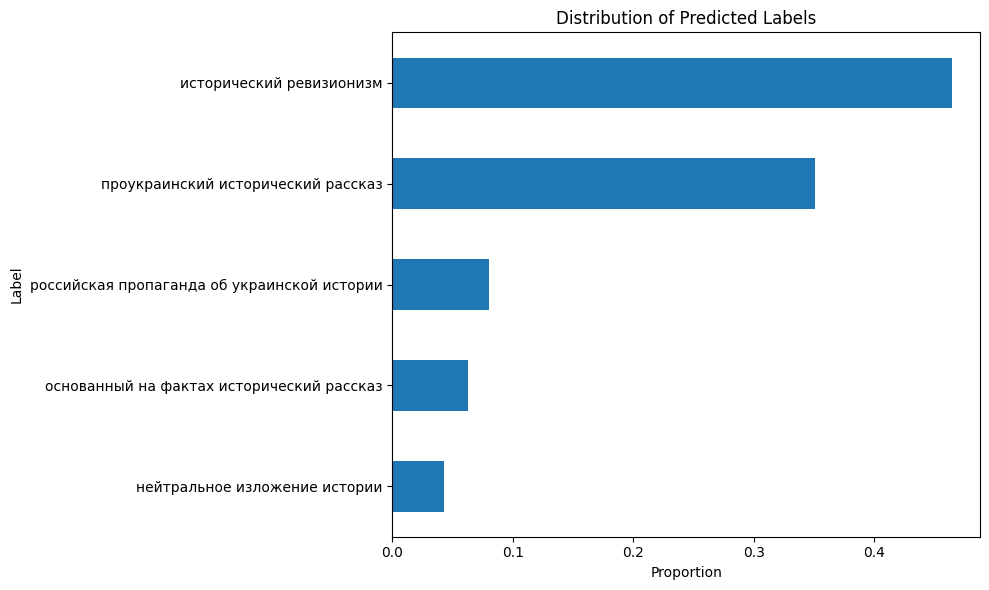

In [11]:
df["predicted_label"] = df[[
    "российская пропаганда об украинской истории",
    "исторический ревизионизм",
    "нейтральное изложение истории",
    "основанный на фактах исторический рассказ",
    "проукраинский исторический рассказ"
]].idxmax(axis=1)

ax = df["predicted_label"].value_counts(normalize=True).sort_values().plot(kind="barh", figsize=(10, 6))
ax.set_title("Distribution of Predicted Labels")
ax.set_xlabel("Proportion")
ax.set_ylabel("Label")
plt.tight_layout()
plt.show()

In [17]:
labels_eng = {
    "российская пропаганда об украинской истории": "Russian propaganda about Ukrainian history",
    "исторический ревизионизм": "Historical revisionism",
    "нейтральное изложение истории": "Neutral account of history",
    "основанный на фактах исторический рассказ": "Fact-based historical narrative",
    "проукраинский исторический рассказ": "Pro-Ukrainian historical narrative"
}


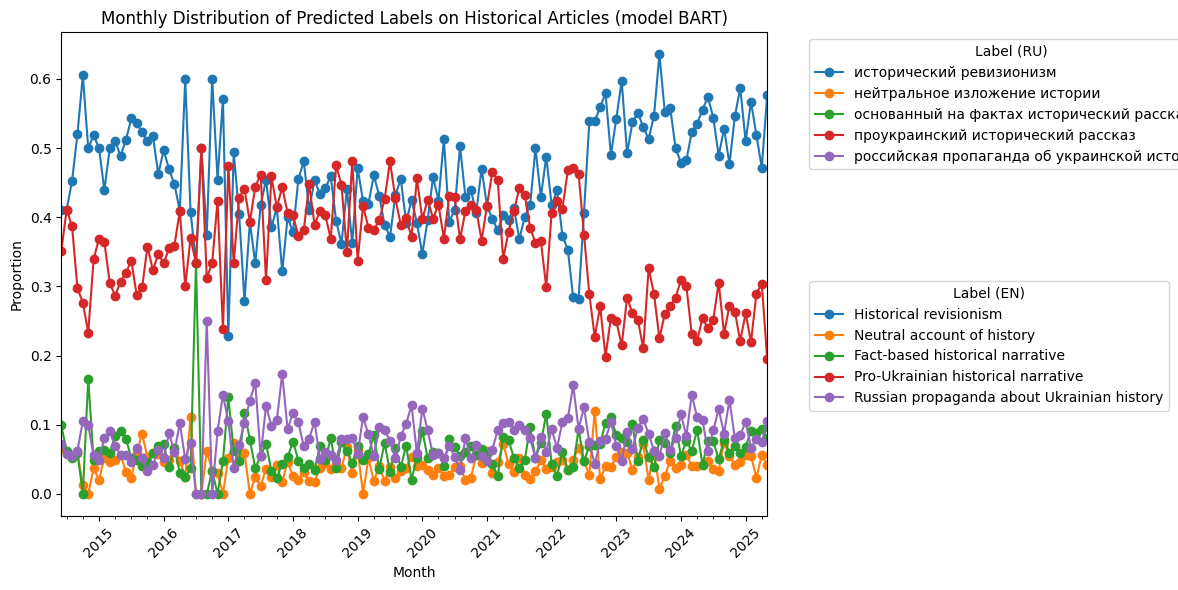

In [ ]:
df["month"] = pd.to_datetime(df["date_parsed"]).dt.to_period("M")
monthly_dist = df.groupby(["month", "predicted_label"]).size().unstack(fill_value=0)
monthly_dist = monthly_dist.div(monthly_dist.sum(axis=1), axis=0)

ax = monthly_dist.plot(kind="line", figsize=(12, 6), marker='o')

plt.title("Monthly Distribution of Predicted Labels on Historical Articles (model BART)")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.xticks(rotation=45)

handles, labels_ru = ax.get_legend_handles_labels()

legend1 = plt.legend(handles, labels_ru, title="Label (RU)", bbox_to_anchor=(1.05, 1), loc='upper left')
legend2 = plt.legend(handles, [labels_eng[lab] for lab in labels_ru], title="Label (EN)", bbox_to_anchor=(1.05, 0.5), loc='upper left')

ax.add_artist(legend1)

plt.tight_layout()
plt.show()

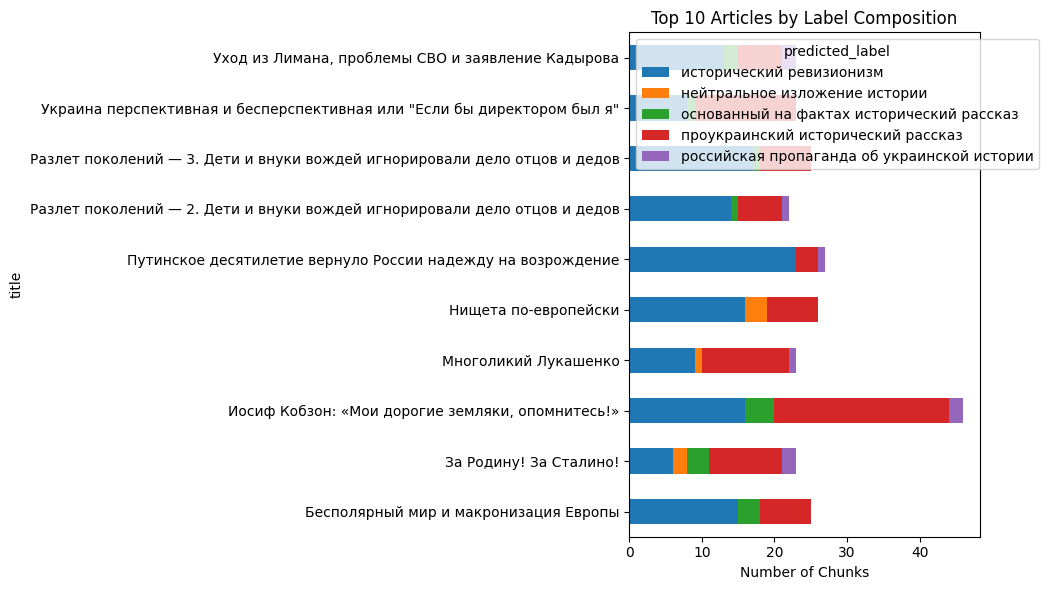

In [9]:
top_articles = df["title"].value_counts().head(10).index
df_top = df[df["title"].isin(top_articles)]

ax = df_top.groupby(["title", "predicted_label"]).size().unstack(fill_value=0).plot(
    kind="barh", stacked=True, figsize=(10, 6))
ax.set_title("Top 10 Articles by Label Composition")
ax.set_xlabel("Number of Chunks")
plt.tight_layout()
plt.show()

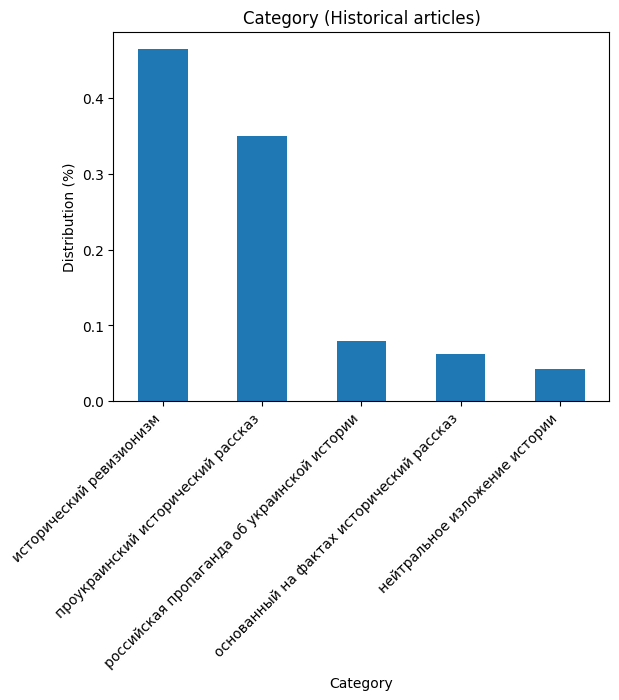

In [ ]:
df["predicted_label"] = df[[
    "российская пропаганда об украинской истории",
    "исторический ревизионизм",
    "нейтральное изложение истории",
    "основанный на фактах исторический рассказ",
    "проукраинский исторический рассказ"
]].idxmax(axis=1)

ax = df["predicted_label"].value_counts(normalize=True).plot(
    kind="bar",
    title="Category (Historical articles)"
)

ax.set_xlabel("Category")
ax.set_ylabel("Distribution (%)")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='right'
)

plt.show()


In [ ]:
print(df[df["российская пропаганда об украинской истории"] > 0.3][["date_parsed", "title"]])


             date_parsed                         title
264  2014-07-02 12:06:00  Donbass locuta, causa finita
973  2014-09-12 16:34:00                   9/11 и MH17


In [11]:
df.head()

,article_id,title,date_parsed,text_snippet,российская пропаганда об украинской истории,исторический ревизионизм,проукраинский исторический рассказ,основанный на фактах исторический рассказ,нейтральное изложение истории,predicted_label,month
0,article_0_1,Формирование образа врага – важнейшая задача у...,2014-06-30 20:15:00,30 июня в интервью информационному центру «Юго...,0.235010,0.213164,0.197592,0.179172,0.175063,российская пропаганда об украинской истории,2014-06
1,article_0_2,Формирование образа врага – важнейшая задача у...,2014-06-30 20:15:00,"й парень, женат, двое детей, не пьющий, из Тер...",0.161422,0.213891,0.203487,0.177706,0.243494,нейтральное изложение истории,2014-06
2,article_0_3,Формирование образа врага – важнейшая задача у...,2014-06-30 20:15:00,"нкции, голодают люди, продуктови карточки.\n— ...",0.180818,0.208023,0.212308,0.220604,0.178245,основанный на фактах исторический рассказ,2014-06
3,article_0_4,Формирование образа врага – важнейшая задача у...,2014-06-30 20:15:00,"е, а ты в бронике, за мой счет, напротив по на...",0.187228,0.225543,0.234684,0.205328,0.147217,проукраинский исторический рассказ,2014-06
4,article_0_5,Формирование образа врага – важнейшая задача у...,2014-06-30 20:15:00,"на много денег наговорили. Раз такое дело, ты...",0.182667,0.268517,0.174938,0.174313,0.199565,исторический ревизионизм,2014-06
